In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import signal
from  scipy import ndimage
import matplotlib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
extrain = pd.read_csv('data/exoTrain.csv')
extest = pd.read_csv('data/exoTest.csv')

In [3]:
def detrender_normalizer(X):
    flux1 = X
    flux2 = ndimage.filters.gaussian_filter(flux1, sigma=10)
    flux3 = flux1 - flux2
    flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
    return flux3normalized

In [4]:
extrain.iloc[:,1:] = extrain.iloc[:,1:].apply(detrender_normalizer,axis=1)
extest.iloc[:,1:] = extest.iloc[:,1:].apply(detrender_normalizer,axis=1)

In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

/Users/abalakrishna/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
def model_evaluator(X, y, model, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    
    bootstrapped_accuracies = list()
    bootstrapped_precisions = list()
    bootstrapped_recalls    = list()
    
    for train_index, test_index in skf.split(X, y):
        print 'in loop'
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        df_train    = X_train.join(y_train)
        df_planet   = df_train[df_train.LABEL == 2].reset_index(drop=True)
        df_noplanet = df_train[df_train.LABEL == 1].reset_index(drop=True)
        df_boot     = df_noplanet
                        
        index = np.arange(0, df_planet.shape[0])
        temp_index = np.random.choice(index, size=df_noplanet.shape[0])
        df_boot = df_boot.append(df_planet.iloc[temp_index])
        
        df_boot = df_boot.reset_index(drop=True)
        X_train_boot = df_boot.drop('LABEL', axis=1)
        y_train_boot = df_boot.LABEL
                    
        est_boot = model.fit(X_train_boot, y_train_boot)
        y_test_pred = est_boot.predict(X_test)
        
        bootstrapped_accuracies.append(accuracy_score(y_test, y_test_pred))
        bootstrapped_precisions.append(precision_score(y_test, y_test_pred, pos_label=2))
        bootstrapped_recalls.append(recall_score(y_test, y_test_pred, pos_label=2))

    print "Average Accuracy " + str( np.mean(bootstrapped_accuracies))
    print "Average Precision " + str( np.mean(bootstrapped_precisions))
    print "Average Recall " + str( np.mean(bootstrapped_recalls))


In [8]:
X = extrain.drop('LABEL', axis=1)
y = extrain.LABEL

In [9]:
model_evaluator(X, y, GradientBoostingClassifier())

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
Average Accuracy 0.99370968241
Average Precision 0.4
Average Recall 0.125


In [10]:
import scipy

In [11]:
def spectrum_getter(X):
    Spectrum = scipy.fft(X, n=X.size)
    return np.abs(Spectrum)

In [12]:
X_train = extrain.drop('LABEL', axis=1)
y_train = extrain.LABEL

X_test = extest.drop('LABEL', axis=1)
y_test = extest.LABEL

In [13]:
new_X_train = X_train.apply(spectrum_getter,axis=1)
new_X_test = X_test.apply(spectrum_getter,axis=1)

In [14]:
# Segregate data for desigining the model and for the final test
y = y_train
X = new_X_train

y_final_test = y_test
X_final_test = new_X_test

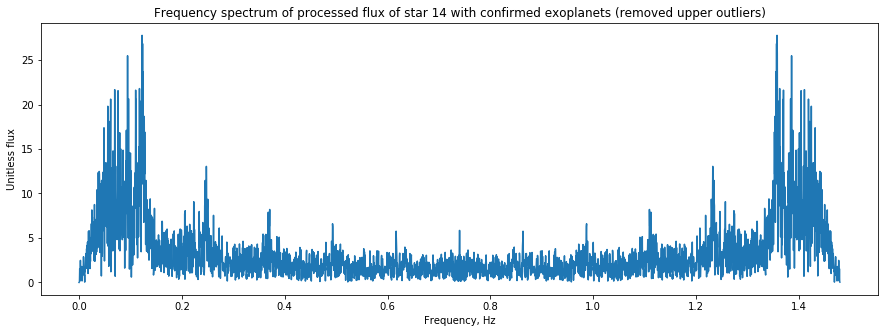

In [15]:
df = X.join(y)
i = 13
spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
plt.figure(figsize=(15,5))
plt.title('Frequency spectrum of processed flux of star {} with confirmed exoplanets (removed upper outliers)'
          .format(i+1))
plt.ylabel('Unitless flux')
plt.xlabel('Frequency, Hz')
plt.plot(freq, spec1)

In [16]:
X = X.iloc[:,:(X.shape[1]//2)]
X_final_test = X_final_test.iloc[:,:(X_final_test.shape[1]//2)]

In [17]:
X_columns = np.arange(len(X.columns))
X_columns = X_columns * (1.0/(36.0*60.0)) # sampling frequency of our data
X.columns = X_columns
X_final_test.columns = X_columns

In [18]:
from sklearn.preprocessing import normalize
X = pd.DataFrame(normalize(X))
X_final_test = pd.DataFrame(normalize(X_final_test))

In [19]:
model_evaluator(X, y, GradientBoostingClassifier())

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
Average Accuracy 0.996462107266
Average Precision 0.9
Average Recall 0.516666666667


In [20]:
def SMOTE_synthesizer(X, y):
        sm = SMOTE(ratio = 1.0)
        X, y = sm.fit_sample(X, y)
        return X, y

In [21]:
X_sm, y_sm = SMOTE_synthesizer(X, y)

/Users/abalakrishna/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
final_model = GradientBoostingClassifier()
final_model.fit(X_sm, y_sm - 1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [30]:
y_pred = final_model.predict(X_final_test)
y_pred_probs = final_model.predict_proba(X_final_test)

In [31]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_final_test-1, y_pred_probs[:, 1] )

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.80


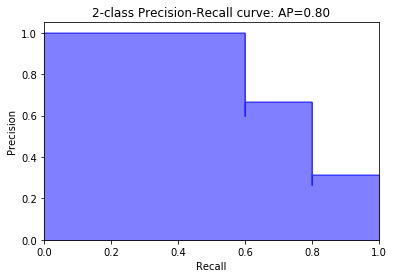

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_final_test-1, y_pred_probs[:, 1])

plt.step(recall, precision, color='b', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_final_test - 1, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       565
          1       1.00      0.60      0.75         5

avg / total       1.00      1.00      1.00       570



In [37]:
kmeans_smote = KMeansSMOTE(
    kmeans_args={
        'n_clusters': 2
    },
    smote_args={
        'k_neighbors': 10
    }
)